In [1]:
import torch
import math
from torch.autograd import Variable
import numpy as np
from torchvision import transforms, datasets

In [106]:
def getData(name='cifar10', train_bs=128, test_bs=1000):
    """
    Get the dataloader
    """
    if name == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        trainset = datasets.CIFAR10(root='../data',
                                    train=True,
                                    download=True,
                                    transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=train_bs,
                                                   shuffle=True)

        testset = datasets.CIFAR10(root='../data',
                                   train=False,
                                   download=False,
                                   transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset,
                                                  batch_size=test_bs,
                                                  shuffle=False)
    if name == 'cifar10_without_dataaugmentation':
        transform_train = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010)),
        ])

        trainset = datasets.CIFAR10(root='../data',
                                    train=True,
                                    download=True,
                                    transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset,
                                                   batch_size=train_bs,
                                                   shuffle=True)

        testset = datasets.CIFAR10(root='../data',
                                   train=False,
                                   download=False,
                                   transform=transform_test)
        test_loader = torch.utils.data.DataLoader(testset,
                                                  batch_size=test_bs,
                                                  shuffle=False)

    return train_loader, test_loader

In [3]:
def group_product(xs, ys):
    """
    the inner product of two lists of variables xs,ys
    :param xs:
    :param ys:
    :return:
    """
    return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])


def group_add(params, update, alpha=1):
    """
    params = params + update*alpha
    :param params: list of variable
    :param update: list of data
    :return:
    """
    for i, p in enumerate(params):
        params[i].data.add_(update[i] * alpha)
    return params


def normalization(v):
    """
    normalization of a list of vectors
    return: normalized vectors v
    """
    s = group_product(v, v)
    s = s**0.5
    s = s.cpu().item()
    v = [vi / (s + 1e-6) for vi in v]
    return v


def get_params_grad(model):
    """
    get model parameters and corresponding gradients
    """
    params = []
    grads = []
    for param in model.parameters():
        if not param.requires_grad:
            continue
        params.append(param)
        grads.append(0. if param.grad is None else param.grad + 0.)
    return params, grads


def hessian_vector_product(gradsH, params, v):
    """
    compute the hessian vector product of Hv, where
    gradsH is the gradient at the current point,
    params is the corresponding variables,
    v is the vector.
    """
    hv = torch.autograd.grad(gradsH,
                             params,
                             grad_outputs=v,
                             only_inputs=True,
                             retain_graph=True)
    return hv


def orthnormal(w, v_list):
    """
    make vector w orthogonal to each vector in v_list.
    afterwards, normalize the output w
    """
    for v in v_list:
        w = group_add(w, v, alpha=-group_product(w, v))
    return normalization(w)


In [98]:
class Trace_Calculator:
    def __init__(self, model, criterion, data=None, dataloader=None, cuda=True):
        assert (data is not None and dataloader is None) or (data is None and dataloader is not None)

        self.model = model.eval()  # Ensure model is in evaluation mode
        self.criterion = criterion
        self.device = 'cuda' if cuda else 'cpu'

        if data is not None:
            self.data = data
            self.full_dataset = False
        else:
            self.data = dataloader
            self.full_dataset = True

        if not self.full_dataset:
            self.inputs, self.targets = self.data
            self.inputs, self.targets = self.inputs.to(self.device), self.targets.to(self.device)

            # Compute gradients for single-batch case
            outputs = self.model(self.inputs)
            loss = self.criterion(outputs, self.targets)
            loss.backward(create_graph=True)

        # Extract parameters and gradients
        self.params, self.gradsH = self.get_params_grad(self.model)

    def trace(self, maxIter=100, tol=1e-3):

        """
        Compute the stochastic trace and return the value for regularization.
        :param maxIter: Maximum number of iterations for the trace estimation.
        :param tol: Tolerance for convergence.
        :param lambda_trace: The regularization strength for the trace term.
        :return: The trace value to be used in the loss for regularization.
        """
        traces = []
        trace = torch.tensor(0.0, device=self.device, requires_grad=True)  # Ensure trace requires gradients
        
        # Start computing trace with gradient computation
        for i in range(maxIter):
            self.model.zero_grad()

            # Generate random vector with requires_grad=True
            v = [torch.randint(0, 2, p.size(), device=p.device) * 2.0 - 1.0 for p in self.params]

            if self.full_dataset:
                _, Hv = self.dataloader_hv_product(v)
            else:
                Hv = self.hessian_vector_product(self.gradsH, self.params, v)

            # Trace estimate (stochastic approximation)
            trace_estimate = self.group_product(Hv, v)
            traces.append(trace_estimate)

            prev_trace = sum(traces) if len(traces) > 0 else 0
            trace = sum(traces) / (i + 1)  # Update trace with the average

            # Ensure the trace is part of the graph (connection between model parameters)
            trace = trace.clone().requires_grad_(True)  # Ensure it has requires_grad=True

            # Convergence check
            if i + 1 > 1 and abs(trace - prev_trace) / (abs(trace) + 1e-6) < tol:
                break

        return trace


    # Function Updates
    def group_product(self, xs, ys):
        """ Compute the inner product of two lists of tensors """
        return sum([torch.sum(x * y) for (x, y) in zip(xs, ys)])

    def get_params_grad(self, model):
        """ Get model parameters and their gradients """
        params = []
        grads = []
        for param in model.parameters():
            if not param.requires_grad:
                continue
            params.append(param)
            grads.append(param.grad if param.grad is not None else torch.zeros_like(param))
        return params, grads

    # Ensure Hessian-Vector Product (Hv) is differentiable
    def hessian_vector_product(self, gradsH, params, v):
        """ Compute Hessian-vector product (Hv) """
        # Ensure gradsH is a list of tensors
        if isinstance(gradsH, torch.Tensor):
            gradsH = [gradsH]  # If it's a single tensor, wrap it in a list

        # Check if gradsH is on the correct device
        gradsH = [g.to(v[0].device) for g in gradsH]
        
        # Compute the Hessian-vector product
        hv = torch.autograd.grad(gradsH, params, grad_outputs=v, only_inputs=True, retain_graph=True)

        return hv
    
    def dataloader_hv_product(self, V):
        """
        Compute the Hessian-vector product using the entire dataset
        """
        device = self.device
        num_data = 0
        THv = [torch.zeros(p.size()).to(device) for p in self.params]
        for inputs, targets in self.data:
            self.model.zero_grad()
            tmp_num_data = inputs.size(0)
            outputs = self.model(inputs.to(device))
            loss = self.criterion(outputs, targets.to(device))
            loss.backward(create_graph=True)
            params, gradsH = self.get_params_grad(self.model)
            self.model.zero_grad()
            Hv = self.hessian_vector_product(gradsH, params, V)
            THv = [THv1 + Hv1 * float(tmp_num_data) + 0. for THv1, Hv1 in zip(THv, Hv)]
            num_data += float(tmp_num_data)
        THv = [THv1 / float(num_data) for THv1 in THv]
        eigenvalue = self.group_product(THv, V)
        return eigenvalue, THv

In [107]:
# get the model 
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg16_bn", pretrained=True)
# change the model to eval mode to disable running stats upate
model.train()

# create loss function
criterion = torch.nn.CrossEntropyLoss()

# get dataset 
train_loader, test_loader = getData()

# for illustrate, we only use one batch to do the tutorial
for inputs, targets in train_loader:
    break

# we use cuda to make the computation fast
model = model.cuda()
inputs, targets = inputs.cuda(), targets.cuda()

Using cache found in C:\Users\PCF/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [100]:
# Initialize the trace calculator
trace_calculator = Trace_Calculator(model, criterion, data=(inputs, targets), cuda=True)

# Compute the trace value
trace = trace_calculator.trace(maxIter=100, tol=1e-3)
# Get the original loss (this would be outside the trace method)
outputs = model(inputs)
loss = criterion(outputs, targets)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lambda_trace = 0.1
# Add the trace regularization term to the loss
regularized_loss = lambda_trace * trace

# Backpropagate the regularized loss
regularized_loss.backward()

# Check the gradients of the model parameters
for param in model.parameters():
    print(param.grad)

# Update the model parameters
optimizer.step()


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [87]:
trace.backward()
print('Gradient of Trace: ', [p.grad for p in trace_calc.params])

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
# get the trace
true_value = trace_calc.trace(maxIter=100,tol = 1e-2)
import time
import matplotlib.pyplot as plt
time_list = []
error = []
for i in range(30):
    time_i = []
    errors = []
    for j in range(3):
        start_time = time.time()
        trace = trace_calc.trace(maxIter=i+1,tol = 1e-2)
        # get the loss
        loss = trace[-1]
        # backpropagate the trace
        loss.backward()
        time_i.append(time.time()-start_time)
        errors.append(torch.norm(true_value - trace[-1]).item())
    errors.sort()
    time_i.sort()
    error.append(errors)
    time_list.append(time_i)

time_list = np.array(time_list).T
iter = np.arange(1,31)
plt.plot(iter,time_list[0])
plt.plot(iter,time_list[1])
plt.plot(iter,time_list[2])
plt.title('Time vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Time (s)')
plt.show()

error = np.array(error).T
plt.plot(iter,error[0])
plt.plot(iter,error[1])
plt.plot(iter,error[2])
plt.title('Error vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

c:\Users\PCF\.conda\envs\SProj\Lib\site-packages\torch\autograd\graph.py:768: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\autograd\engine.cpp:1208.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


KeyboardInterrupt: 

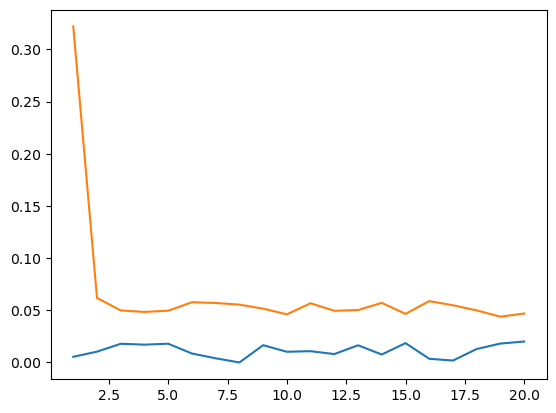

Time for loss and backward: 0.011313939094543457
Time for trace and backward: 0.06570971012115479
Average slowdown: 5.807854326601917


In [ ]:
times = []
times_trace = []
criterion = torch.nn.CrossEntropyLoss()
for i in range(20):
    start_time = time.time()
    loss = criterion(model(inputs), targets)
    loss.backward()
    times.append(time.time()-start_time)
    start_time = time.time()
    trace = trace_calc.trace(maxIter=1,tol = 1e-2)
    loss = trace[-1]
    loss.backward()
    times_trace.append(time.time()-start_time)
plt.plot(iter,times)
plt.plot(iter,times_trace)
plt.show()
print('Time for loss and backward:',np.mean(times))
print('Time for trace and backward:',np.mean(times_trace))
print('Average slowdown:',np.mean(times_trace)/np.mean(times))

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, n_samples=10, update_each=10, seed=42):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)  # 8x8 feature map after two conv layers
        self.fc2 = nn.Linear(512, 10)  # 10 classes for CIFAR-10
        
        # Track Hessian trace for each parameter
        self.hessian_traces = {}
        
        # Parameters for Hutchinson's approximation of Hessian trace
        self.n_samples = n_samples
        self.update_each = update_each
        self.seed = seed
        self.state = {}
        for p in self.parameters():
            self.state[p] = {"hessian step": 0}
            p.hess = torch.zeros_like(p)  # Initialize Hessian trace accumulation
        
    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)  # Flatten the feature map
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def get_params(self):
        """Helper function to get model parameters."""
        return list(self.parameters())

    def zero_hessian(self):
        """
        Zeros out the accumulated Hessian traces for each parameter.
        """
        for p in self.get_params():
            p.hess.zero_()

    def estimate_hessian_trace(self, data, target, num_samples=10):
        """
        Estimate the trace of the Hessian for regularization.
        """
        self.zero_grad()
        output = self(data)
        loss = nn.CrossEntropyLoss()(output, target)
        grad = torch.autograd.grad(loss, self.parameters(), create_graph=True)
        
        trace_estimate = 0.0
        for _ in range(num_samples):
            # Sample a random direction v for Hessian-vector product
            v = [torch.randn_like(p).to(p.device) for p in self.parameters()]
            Hv = self.hessian_vector_product(grad, v)
            # Add the trace estimate
            trace_estimate += sum(torch.sum(hv * vi) for hv, vi in zip(Hv, v))
        
        return trace_estimate / num_samples

    def hessian_vector_product(self, grad, v):
        """
        Compute the Hessian-vector product.
        """
        Hv = []
        for g, p, vi in zip(grad, self.get_params(), v):
            # Compute the gradient of the gradient (Hessian-vector product)
            grad_grad = torch.autograd.grad(g, p, grad_outputs=vi, retain_graph=True)[0]
            Hv.append(grad_grad)
        return Hv

    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """
        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if self.state[p]["hessian step"] % self.update_each == 0:  # compute the trace only each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if next(self.parameters()).device != params[0].device:  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(params[0].device).manual_seed(self.seed)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            # Rademacher distribution {-1.0, 1.0}
            zs = [torch.randint(0, 2, p.size(), generator=self.generator, device=p.device) * 2.0 - 1.0 for p in params]
            h_zs = torch.autograd.grad(
                grads, params, grad_outputs=zs, only_inputs=True, retain_graph=i < self.n_samples - 1)
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += h_z * z / self.n_samples  # approximate the expected values of z*(H@z)
            
    def get_hessian_trace(self):
        """
        Retrieve the accumulated Hessian trace for regularization.
        """
        total_trace = 0
        for p in self.get_params():
            total_trace += torch.sum(p.hess)
        return total_trace

# Initialize the model, optimizer
model = SimpleCNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training loop with regularization term based on Hessian trace
def train(model, train_loader, optimizer, num_samples=10, lambda_reg=0.01):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = nn.CrossEntropyLoss()(output, target)

        # Set the Hessian and use it as a regularization term
        model.set_hessian()
        hessian_trace = model.get_hessian_trace()
        regularization_term = lambda_reg * hessian_trace  # Regularization strength
        total_loss = regularization_term

        # Backward pass
        total_loss.backward()
        optimizer.step()

        print(f"Loss: {loss.item()}, Regularization Term: {regularization_term.item()}, Total Loss: {total_loss.item()}")

# Assuming you have a DataLoader `train_loader` available for CIFAR-10
train(model, train_loader, optimizer, num_samples=10, lambda_reg=0.01)


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [ ]:
import torch

# Define a function to estimate the trace of the Hessian using Hutchinson's estimator
def hutchinson_trace_estimator(model, loss_fn, data, labels, num_samples=10):
    """
    Estimate the trace of the Hessian using Hutchinson's method.
    Args:
        model: PyTorch model.
        loss_fn: Loss function.
        data: Input data (tensor).
        labels: Ground truth labels (tensor).
        num_samples: Number of stochastic samples for estimating the trace.
    Returns:
        The estimated trace of the Hessian.
    """
    # Ensure the model is in evaluation mode for inference
    model.eval()

    # Generate random vectors, ensure they require gradients for backprop
    d = sum(p.numel() for p in model.parameters())  # Total number of parameters
    random_vectors = torch.randn((num_samples, d), device=data.device, requires_grad=True)  # Random vectors with requires_grad

    # Initialize trace estimate
    trace_estimate = 0.0

    # Compute loss and trace estimation
    for i in range(num_samples):
        model.zero_grad()
        # Compute model output
        outputs = model(data)
        
        # Compute the loss (e.g., MSE, CrossEntropy, etc.)
        loss = loss_fn(outputs, labels)

        # Compute gradient of the loss with respect to model parameters
        loss.backward()

        # Flatten model parameters' gradients
        flattened_grads = torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None])

        # Compute the dot product of the flattened gradient and the random vector
        grad_dot = torch.dot(flattened_grads, random_vectors[i])

        # Add to trace estimate
        trace_estimate += grad_dot

    # Return average trace estimate
    return trace_estimate / num_samples


# Example of using Hutchinson's trace as a regularizer in the loss function
def loss_with_regularizer(model, loss_fn, data, labels, lambda_reg=0.1, num_samples=10):
    """
    Compute the total loss including the regularizer based on the Hessian trace estimate.
    Args:
        model: PyTorch model.
        loss_fn: Loss function.
        data: Input data (tensor).
        labels: Ground truth labels (tensor).
        lambda_reg: Weight of the regularizer.
        num_samples: Number of stochastic samples for estimating the trace.
    Returns:
        Total loss including the regularizer.
    """
    # Standard loss (e.g., CrossEntropy, MSE, etc.)
    base_loss = loss_fn(model(data), labels)
    
    # Estimate the trace of the Hessian using Hutchinson's method
    trace_estimate = hutchinson_trace_estimator(model, loss_fn, data, labels, num_samples)
    
    # Add the regularization term (scaled by lambda_reg)
    total_loss =lambda_reg * trace_estimate

    return total_loss


# Example usage
if __name__ == '__main__':
    # Dummy example: A simple feedforward neural network
    class SimpleNN(torch.nn.Module):
        def __init__(self, input_dim, output_dim):
            super(SimpleNN, self).__init__()
            self.fc1 = torch.nn.Linear(input_dim, 128)
            self.fc2 = torch.nn.Linear(128, output_dim)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            return self.fc2(x)

    # Generate dummy data
    input_dim = 10  # Number of features
    output_dim = 2  # Number of output classes
    data = torch.randn(32, input_dim)  # Batch of 32 samples
    labels = torch.randint(0, output_dim, (32,))  # Random labels for classification

    # Initialize model and loss function
    model = SimpleNN(input_dim, output_dim)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Compute loss with regularizer
    total_loss = loss_with_regularizer(model, loss_fn, data, labels, lambda_reg=0.1, num_samples=10)

    print(f"Total Loss with Regularizer: {total_loss.item()}")

    # Backpropagate the total loss
    total_loss.backward()

    # Example optimizer step (assuming you have an optimizer set up)
    # optimizer.step()
    print([p.grad for p in model.parameters()])


Total Loss with Regularizer: -0.010144166648387909
[tensor([[-5.6572e-03,  1.8344e-02,  2.3845e-02,  ...,  4.7959e-03,
         -2.3332e-02, -4.3313e-02],
        [ 1.3667e-02,  1.8654e-02, -9.2730e-03,  ...,  1.2897e-02,
          9.5079e-03,  1.2203e-02],
        [ 1.0997e-01,  4.0434e-02, -5.8277e-02,  ..., -2.7786e-02,
          1.2812e-01,  1.3640e-02],
        ...,
        [-3.4944e-02, -4.4106e-02, -1.4018e-01,  ..., -1.3359e-01,
          1.5634e-02, -2.9434e-02],
        [-3.5237e-03,  1.1181e-03, -6.8924e-03,  ..., -4.6386e-03,
         -3.6787e-03,  2.0746e-03],
        [ 8.6955e-05,  1.0686e-04,  1.3925e-04,  ...,  9.9665e-05,
          4.3119e-05, -2.0538e-04]]), tensor([ 5.8456e-03,  9.6895e-03, -5.8108e-03,  8.5182e-03,  2.5778e-03,
        -9.1953e-03, -1.2349e-02, -7.5696e-04, -2.7112e-02,  2.8709e-04,
         1.3169e-02,  1.1682e-03,  2.4907e-02,  1.1012e-01,  1.0017e-02,
         3.2218e-02,  9.2098e-04,  6.5205e-02,  3.6305e-02, -5.9459e-03,
         1.0567e-02,  2

In [8]:
import torch
import torch.nn as nn
class HessianTraceModel(nn.Module):
    def __init__(self, model, n_samples=1, seed=42):
        super().__init__()
        self.model = model
        self.n_samples = n_samples  # Number of Hutchinson samples
        self.seed = seed
        self.generator = torch.Generator()

    def get_params(self):
        return [p for p in self.model.parameters() if p.requires_grad]

    def compute_hessian_trace(self, loss):
        params = self.get_params()  # List of model parameters
        # Compute gradients of the loss w.r.t. parameters
        grads = torch.autograd.grad(loss, params, create_graph=True)
        trace = torch.tensor(0.0, device=loss.device)
        for _ in range(self.n_samples):
            # Generate random Rademacher vectors
            zs = [torch.randint(0, 2, p.size(), device=p.device) * 2.0 - 1.0 for p in params]
            # Compute Hessian-vector product H z
            h_zs = torch.autograd.grad(grads, params, grad_outputs=zs, create_graph=True)
            # Compute z^T H z
            sample_trace = sum((h_z * z).sum() for h_z, z in zip(h_zs, zs))
            trace = trace + sample_trace / self.n_samples
        return trace

# Example usage
def train_with_trace_regularization():
    # Simple model
    class SimpleNN(torch.nn.Module):
        def __init__(self, input_dim=10, output_dim=1):
            super(SimpleNN, self).__init__()
            self.fc1 = torch.nn.Linear(input_dim, 128)
            self.fc2 = torch.nn.Linear(128, output_dim)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            return self.fc2(x)
    model = SimpleNN()
    wrapper = HessianTraceModel(model, n_samples=20)
    
    # Dummy data
    batch_size = 128
    input_dim = 10
    x = torch.randn(batch_size, input_dim)  # Input: 32 samples, 10 features
    true_W = torch.ones(1, input_dim) * 0.1  # True weight: [0.1, 0.1, ..., 0.1]
    true_b = torch.tensor([0.5])            # True bias: 0.5
    y = x @ true_W.T + true_b + torch.randn(batch_size, 1) * 0.01  # Output with small noise
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    
    traces = []
    losses = []
    for _ in range(1800):
        optimizer.zero_grad()
        output = model(x)
        primary_loss = nn.MSELoss()(output, y)
        
        # Compute Hessian trace of primary_loss
        trace = wrapper.compute_hessian_trace(primary_loss)
        
        # Total loss with trace regularization
        lambda_reg = 0.01
        total_loss = primary_loss + lambda_reg * trace
        
        # Backpropagate
        total_loss.backward()
        optimizer.step()
        
        print(f"Primary Loss: {primary_loss.item():.4f}, Trace: {trace.item():.4f}, "
              f"Total Loss: {total_loss.item():.4f}")
        traces.append(trace.item())
        losses.append(total_loss.item())
    
    return traces, losses


traces, losses = train_with_trace_regularization()

Primary Loss: 0.3340, Trace: 44.2215, Total Loss: 0.7762
Primary Loss: 0.2547, Trace: 52.2637, Total Loss: 0.7773
Primary Loss: 0.2069, Trace: 51.0932, Total Loss: 0.7179
Primary Loss: 0.1652, Trace: 51.3175, Total Loss: 0.6784
Primary Loss: 0.1374, Trace: 48.0797, Total Loss: 0.6182
Primary Loss: 0.1206, Trace: 42.7330, Total Loss: 0.5479
Primary Loss: 0.1083, Trace: 49.5823, Total Loss: 0.6041
Primary Loss: 0.0999, Trace: 47.3647, Total Loss: 0.5736
Primary Loss: 0.0903, Trace: 38.2815, Total Loss: 0.4731
Primary Loss: 0.0856, Trace: 46.6177, Total Loss: 0.5518
Primary Loss: 0.0801, Trace: 45.2109, Total Loss: 0.5322
Primary Loss: 0.0751, Trace: 49.9454, Total Loss: 0.5746
Primary Loss: 0.0710, Trace: 50.5999, Total Loss: 0.5770
Primary Loss: 0.0674, Trace: 42.9049, Total Loss: 0.4965
Primary Loss: 0.0642, Trace: 49.4612, Total Loss: 0.5588
Primary Loss: 0.0624, Trace: 39.3347, Total Loss: 0.4558
Primary Loss: 0.0597, Trace: 48.1588, Total Loss: 0.5413
Primary Loss: 0.0574, Trace: 61

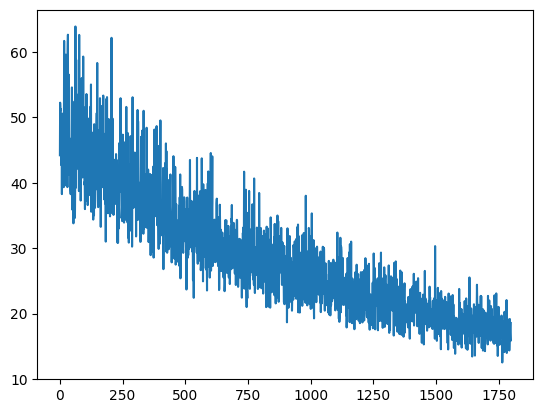

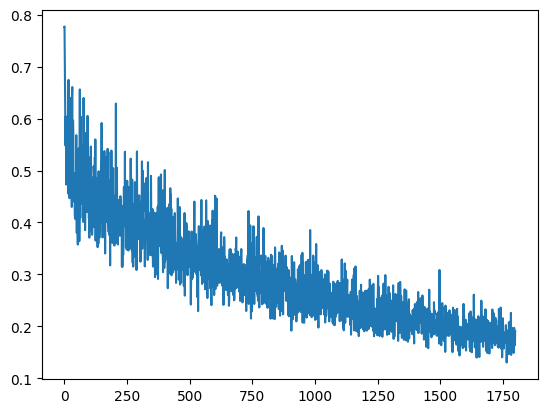

In [9]:
import matplotlib.pyplot as plt

plt.plot(traces)
plt.show()

plt.plot(losses)
plt.show()

In [10]:
import torch

class Trace_Dropout_Calculator:
    def __init__(self, model, criterion, p=0.05, data=None, dataloader=None, device = 'cuda'):
        self.model = model.eval()
        self.criterion = criterion
        self.device = device
        self.data = data
        self.dataloader = dataloader
        self.p = p

        if data is not None:
            self.inputs, self.targets = data
            self.inputs, self.targets = self.inputs.to(self.device), self.targets.to(self.device)
            self.full_dataset = False

            outputs = self.model(self.inputs)
            loss = self.criterion(outputs, self.targets)
            loss.backward(create_graph=True)
        else:
            self.full_dataset = True
            n_batches = 0
            for inputs, targets in self.dataloader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward(create_graph=True)
                n_batches += 1

            for param in self.model.parameters():
                if param.requires_grad and param.grad is not None:
                    param.grad /= n_batches

        self.params, self.gradsH = self.get_params_grad()

    def get_params_grad(self):
        """Get model parameters and their gradients"""
        params = []
        grads = []
        for param in self.model.parameters():
            if param.requires_grad:
                params.append(param)
                grads.append(param.grad if param.grad is not None else torch.zeros_like(param))
        return params, grads

    def sample_q_vector(self, shape, device):
        """Generate Q(p)-distributed vector: ±1 with prob p, 0 with prob 1-2p"""
        probs = torch.rand(shape, device=device)
        mask = probs < 2 * self.p
        signs = torch.randint_like(probs, low=0, high=2) * 2 - 1  # ±1
        return torch.where(mask, signs, torch.zeros_like(signs))

    def compute_trace_dropout(self, maxIter=100, tol=1e-3):
        trace = torch.tensor(0.0, device=self.device)
        for i in range(maxIter):
            # Q(p)-based noise vector for each parameter
            sigmas = [self.sample_q_vector(p.size(), p.device) for p in self.params]

            # v = g · σ (element-wise)
            v = [g * s for g, s in zip(self.gradsH, sigmas)]

            # h = dv/dω
            h = torch.autograd.grad(v, self.params, grad_outputs=[torch.ones_like(vv) for vv in v], retain_graph=True, create_graph=True)

            # t = σ^T h
            t = sum((s * hh).sum() for s, hh in zip(sigmas, h))
            old_trace = trace
            trace = trace * i / (i + 1) + t / (i + 1)

            if i > 1 and abs(trace - old_trace) / (abs(trace) + 1e-6) < tol:
                break

        return trace


In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD
import time
import numpy as np

# Make sure this class is defined from previous messages
# from trace_dropout_calculator import Trace_Dropout_Calculator
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train_with_trace_dropout_regularization(p = 0.3):
    # Simple model
    class SimpleNN(torch.nn.Module):
        def __init__(self, input_dim=10, output_dim=1):
            super(SimpleNN, self).__init__()
            self.fc1 = torch.nn.Linear(input_dim, 128)
            self.fc2 = torch.nn.Linear(128, output_dim)

        def forward(self, x):
            x = torch.relu(self.fc1(x))
            return self.fc2(x)

    model = SimpleNN()
    
    # Dummy data
    batch_size = 128
    input_dim = 10
    x = torch.randn(batch_size, input_dim)
    true_W = torch.ones(1, input_dim) * 0.1
    true_b = torch.tensor([0.5])
    y = x @ true_W.T + true_b + torch.randn(batch_size, 1) * 0.01

    x, y = x.to(device), y.to(device)
    model = model.to(device)

    optimizer = SGD(model.parameters(), lr=0.01)

    traces = []
    losses = []

    for step in range(600):
        optimizer.zero_grad()
        
        # Forward pass
        output = model(x)
        primary_loss = nn.MSELoss()(output, y)

        # Hessian trace regularization (SEHT-D)
        trace_calculator = Trace_Dropout_Calculator(model, nn.MSELoss(), data=(x, y), p=p, device='cpu')
        trace = trace_calculator.compute_trace_dropout(maxIter=20)

        # Total loss
        lambda_reg = 0.01
        total_loss = primary_loss + lambda_reg * trace

        # Backward and update
        total_loss.backward()
        optimizer.step()

        # print(f"[{step:04d}] Primary Loss: {primary_loss.item():.4f}, "
        #       f"Trace: {trace.item():.4f}, Total Loss: {total_loss.item():.4f}")
        
        traces.append(trace.item())
        losses.append(total_loss.item())

    trace_model = HessianTraceModel(model, 20,42)
    trace = trace_model.compute_hessian_trace(nn.MSELoss()(model(x), y))
    print(trace.item(), primary_loss.item(), total_loss.item(), end = "---")
    return traces, losses


l = np.linspace(0.05,0.45,11)
for i in l:
    print(i, end= ":")
    start_time = time.time()
    traces, losses = train_with_trace_dropout_regularization(i)
    print(time.time()-start_time)

0.05:

c:\Users\MUHAMMAD AHMAD\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


TypeError: 'MSELoss' object is not iterable

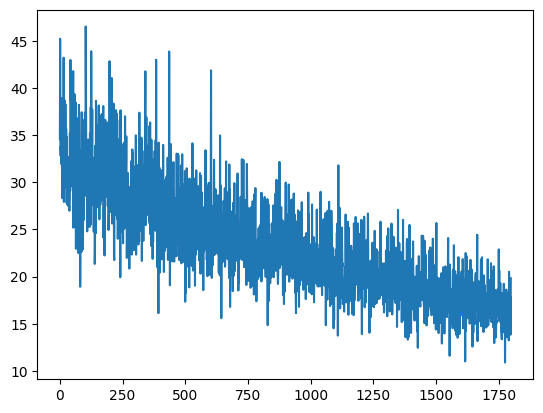

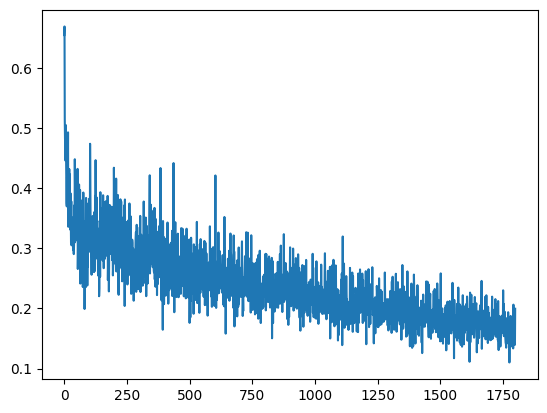

In [15]:
import matplotlib.pyplot as plt

plt.plot(traces)
plt.show()

plt.plot(losses)
plt.show()